<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/K-Nearest%20Neighbours%20(KNN)%20Classification/Hands-On%20Lab%3A%20K-Nearest%20Neighbours%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Nearest Neighbors (KNN) Classification

In this lab, you will implement a K-Nearest Neighbors classifier from scratch, tune its parameters, and apply it to real data. Along the way, you’ll answer conceptual questions and create visualizations to deepen your understanding. By the end, you will have a clear grasp of how KNN works, how to evaluate it using accuracy and confusion matrices, and why practices like feature scaling and proper data splitting are critical.


## Overview of KNN

K-Nearest Neighbors (KNN) is a simple, instance-based learning algorithm used for classification (and regression). For classification, KNN makes predictions by looking at the K training examples closest (in feature space) to a new data point, and assigning the majority class among those neighbors. It is considered a lazy learning method because it does not build an explicit model; instead, all training data is stored, and generalization is postponed until a query (prediction) is made.

How KNN Classification Works:

1.	Choose K: Decide on the number of neighbors (K) to use for predictions.
2.	Compute Distances: To classify a new point, compute the distance between this point and all points in the training set (commonly using Euclidean distance).
3.	Find Nearest Neighbors: Identify the K training points with the smallest distances to the new point.
4.	Majority Vote: Among these K neighbors, count the occurrences of each class and take the majority vote. The new point is predicted to belong to the class with the most votes.
5.	Return the Prediction: Assign the predicted class to the new point.


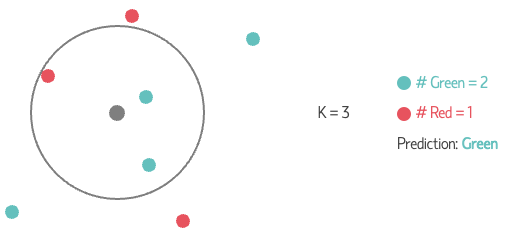

For example, if K=3 and among the 3 nearest neighbors 2 are class Green and 1 is class Red, the new point will be classified as class Green.



## Visual K Progression

To understand how the choice of K affects predictions, let's visualize how KNN makes decisions for different K values. We'll create a simple 2D dataset and observe how the prediction changes as we vary K from 1 to 5.

For each value of K, we'll:
- Circle the K nearest neighbors to a query point
- Count votes from each class (e.g., "# Green = 2, # Red = 1")
- Show the final prediction based on majority vote

This visualization will demonstrate:
- **Small K (K=1, K=2)**: More sensitive to individual points, can be noisy
- **Medium K (K=3, K=4)**: More balanced predictions
- **Larger K (K=5)**: Smoother decision boundaries, more stable predictions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from collections import Counter

# Create a simple 2D dataset
np.random.seed(42)
# Class 0 (Red): centered around (2, 2)
class_0 = np.random.randn(15, 2) * 0.5 + np.array([2, 2])
# Class 1 (Green): centered around (4, 4)
class_1 = np.random.randn(15, 2) * 0.5 + np.array([4, 4])

X_train = np.vstack([class_0, class_1])
y_train = np.array([0]*15 + [1]*15)

# Query point to classify
query_point = np.array([3.0, 3.5])

# Calculate distances from query point to all training points
distances = np.sqrt(np.sum((X_train - query_point)**2, axis=1))

# Create subplots for K=1 to K=5
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
k_values = [1, 2, 3, 4, 5]

for idx, k in enumerate(k_values):
    ax = axes[idx]
    
    # Find K nearest neighbors
    nearest_indices = np.argsort(distances)[:k]
    nearest_labels = y_train[nearest_indices]
    
    # Count votes
    vote_counts = Counter(nearest_labels)
    prediction = max(vote_counts, key=vote_counts.get)
    
    # Plot all training points
    ax.scatter(class_0[:, 0], class_0[:, 1], c='red', s=100, alpha=0.6, label='Class 0 (Red)', edgecolors='black')
    ax.scatter(class_1[:, 0], class_1[:, 1], c='green', s=100, alpha=0.6, label='Class 1 (Green)', edgecolors='black')
    
    # Highlight K nearest neighbors with circles
    for i in nearest_indices:
        circle = Circle(X_train[i], 0.2, color='blue', fill=False, linewidth=2)
        ax.add_patch(circle)
    
    # Plot query point
    pred_color = 'red' if prediction == 0 else 'green'
    ax.scatter(query_point[0], query_point[1], c=pred_color, s=300, marker='*', 
               edgecolors='black', linewidth=2, label='Query Point', zorder=5)
    
    # Add vote count and prediction text
    red_votes = vote_counts.get(0, 0)
    green_votes = vote_counts.get(1, 0)
    pred_class = "Red" if prediction == 0 else "Green"
    
    ax.text(0.5, 0.95, f'K = {k}', transform=ax.transAxes, fontsize=14, 
            fontweight='bold', ha='center', va='top')
    ax.text(0.5, 0.88, f'# Red = {red_votes}, # Green = {green_votes}', 
            transform=ax.transAxes, fontsize=11, ha='center', va='top')
    ax.text(0.5, 0.80, f'Prediction: {pred_class}', transform=ax.transAxes, 
            fontsize=12, fontweight='bold', ha='center', va='top', 
            bbox=dict(boxstyle='round', facecolor=pred_color, alpha=0.3))
    
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 6)
    ax.set_xlabel('Feature 1', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Feature 2', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('How K Affects KNN Predictions: Visualizing K Nearest Neighbors', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- As K increases, the prediction becomes more stable and less sensitive to individual points")
print("- Small K values can lead to overfitting (too sensitive to noise)")
print("- Large K values can lead to underfitting (too smooth, may ignore local patterns)")

> **Question**: In KNN classification, the parameter K refers to:
>
> A. The number of nearest neighbors used to determine the class of a new data point.
>
> B. The number of features (dimensions) in the dataset.
>
> C. The number of classes in the classification problem.
>
> D. The exponent used in the distance calculation.

## Bias-Variance Trade-off in KNN

The choice of K has a significant effect on the model’s complexity and performance:

- Small K (e.g., K=1) tends to lead to complex, highly flexible decision boundaries that closely follow the training data. This can result in overfitting (low bias, high variance) – high accuracy on training data but low accuracy on unseen data.
- Large K (e.g., K large relative to number of samples) produces smoother, less complex decision boundaries because predictions are averaged over many neighbors. This can result in underfitting (high bias, low variance) – both training and validation accuracy might be low because the model is too simple to capture patterns.

We will observe this behavior when we experiment with different values of K.

## Distance Metrics and Feature Scaling

KNN relies on a distance measure to determine “nearest” neighbors. Common choices include:

-	Euclidean distance (L2 norm)
-	Manhattan distance (L1 norm)
-	Cosine distance, etc.

Feature scaling is crucial for KNN because the distance computation is sensitive to the scale of features. If one feature has a much larger range than others, it can dominate the distance calculation and distort nearest neighbor relationships. We typically address this by scaling or standardizing features (e.g., using z-scores) so that all features contribute more equally to distance calculations. You will see the impact of scaling when we apply KNN to a real dataset.

> **Question**: When using KNN on a dataset with features measured in very different units (e.g., one feature in the range 0-1000 and another in 0-1), what is the best practice?
>
> A. Normalize or standardize the features so they have similar scales before training KNN.
>
> B. Remove the feature with the larger range to avoid dominance in distance calculation.
>
> C. Use a different distance metric that ignores scale differences, so scaling is not needed.
>
> D. Increase K proportionally to the range differences to offset the scale issue.

## KNN Algorithm: Pseudocode

Before implementing KNN from scratch, let's understand the algorithm's structure through formal pseudocode. KNN is a **lazy learning** algorithm, meaning it doesn't build an explicit model during training—it simply stores the training data and performs all computation during prediction.

### Formal Pseudocode

```
# ============================================
# Inputs
# ============================================
# data ← training set of N examples (x, y)
# k ← number of neighbours
# metric ← distance function (e.g., Euclidean, Manhattan)
# X_query ← set of examples to classify

# ============================================
# ----- "fit" (lazy) -----
# ============================================
X_train ← data.x
y_train ← data.y

# ============================================
# ----- predict -----
# ============================================
ŷ ← list of length |X_query|
FOR i = 1 TO |X_query| DO
    x* ← X_query[i]
    d ← distances from x* to all X_train using metric
    J ← indices of the k smallest values in d
    ŷ[i] ← majority_vote(y_train[J])
END FOR
RETURN ŷ
```

### Key Observations

1. **Lazy Learning**: The `fit` phase simply stores the training data—no model parameters are learned.
2. **Prediction Phase**: All the work happens during prediction:
   - Calculate distances from the query point to all training points
   - Find the K nearest neighbors
   - Take a majority vote among their labels
3. **Computational Cost**: For each prediction, we compute distances to all N training points, making KNN O(N) per prediction.

Now let's implement this algorithm from scratch!

## Implementing a Custom KNN Classifier

Instead of using sklearn.neighbors.KNeighborsClassifier, we will build our own MyKNNClassifier from scratch. This will solidify our understanding of how the algorithm works internally. We will incorporate some best practices into our implementation, such as input validation (shape checks, value checks) and ensuring reproducibility where relevant.

Let’s start by implementing the MyKNNClassifier class with the following specifications:
- It should follow the basic structure of scikit-learn classifiers, with fit and predict methods.
-	In fit(X, y), simply store the training data (X and y). We will use underscores (X_train_, y_train_) to indicate stored fitted data attributes.
-	In predict(X), use the KNN algorithm: for each sample in X, compute distances to all points in X_train_, find the K nearest neighbors, and return the majority class among those neighbors.
-	Include shape guards and input validation:
  -	Check that X and y have appropriate shapes in fit (e.g., same number of samples).
  -	Ensure that k is a positive integer and not greater than the number of training samples.
  -	Optionally, ensure that the number of features in any data passed to predict matches the number in X_train_.
-	We will use Euclidean distance by default (you can allow other metrics as an extension). To compute distances efficiently, we can use sklearn.metrics.pairwise_distances or NumPy operations.
-	Use the Python collections.Counter to perform the majority vote among neighbors’ labels.

Below is a scaffold of the MyKNNClassifier class. Fill in the TODO sections to complete the implementation:

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import pairwise_distances

class MyKNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, k=3, metric='euclidean'):
        """KNN classifier: majority vote among k nearest neighbours."""
        self.k = k
        self.metric = metric

    def fit(self, X, y):
        """'Fit' (lazy): store training arrays to use during predict()."""
        X = np.asarray(X)
        y = np.asarray(y)
        # TODO: store training data (use attribute names referenced in predict)
        self.X_train_ = _________
        self.y_train_ = _________
        return self

    def predict(self, X):
        """Return one predicted label per row in X (same order as X)."""
        X = np.asarray(X)

        # TODO: prepare output array with same dtype as training labels
        y_pred = _________   # e.g., np.empty(X.shape[0], dtype=self.y_train_.dtype)

        for i, x in enumerate(X):
            # TODO: compute distances from x to all training points
            d = _________     # use pairwise_distances(self.X_train_, x[None, :], metric=self.metric).ravel()

            # TODO: get indices of the k smallest distances (nearest neighbours)
            J = _________     # e.g., np.argsort(d)[:self.k]

            # TODO: majority vote (deterministic tie-break via np.unique)
            labels, counts = _________   # e.g., np.unique(self.y_train_[J], return_counts=True)
            y_pred[i] = _________        # e.g., labels[np.argmax(counts)]

        # TODO: return predictions as a 1D NumPy array
        return _________

Once you have filled in the implementation, let’s test our custom classifier on a simple dataset to ensure it works as expected.

## A Dataset for Visualization

To visualize how KNN works, we’ll use R ElemStatLearn's "Simulated Mixture Gaussian" dataset:
-	Total points: 200 (100 per class).
-	Classes: 2
-	Features: $x_1$ and $x_2$ (2D), which we can plot on a plane.
-	This dataset is partially overlapping and not linearly separable, which is perfect for exploring KNN decision boundaries and performance.

Let’s load the dataset:

In [ ]:
import pandas as pd

# URL for our dataset, mixture-example.csv
URL = "https://drive.google.com/file/d/1l0QDFXeyrelvjXlyhnj4ppP_SSTABIKp/view?usp=sharing"
FILE_PATH = "https://drive.google.com/uc?export=download&id=" + URL.split("/")[-2]

data = pd.read_csv(FILE_PATH)

# Filter data by labels
X = data[['X', 'Y']].values
y = data['Label'].values

print("Dataset shape:", X.shape, "Labels shape:", y.shape)


Running the above code will load the dataset and print the shapes. You should see Dataset shape: (200, 2) Labels shape: (200,) confirming we have 200 samples with 2 features each. Next, let’s visualize this dataset to understand its structure:

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(X[y==0, 0], X[y==0, 1], color='lightblue', label='0', marker='o')
plt.scatter(X[y==1, 0], X[y==1, 1], color='orange', label='1', marker='o')

plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)
plt.axis([-4, 4, -4, 4])
plt.legend()
plt.grid(True)
plt.show()

In the scatter plot, points of different colors represent the two classes (for example, blue for class 0 and red for class 1). Notice that the classes are composed of multiple clusters spread around the space, with some overlap between the blue and red points. This will make the classification task non-trivial, which is great for exploring how KNN behaves.

Splitting into Train, Validation, and Test Sets

To evaluate our model properly and tune the hyperparameter K, we will split the data into three sets:
	•	Training set (Train) – used to fit the KNN model.
	•	Validation set (Val) – used to select the best K (tuning the hyperparameter). We will test different K values on this set.
	•	Test set (Test) – used only for final evaluation of the model’s performance after tuning, to simulate unseen data.

We’ll do a 60%/20%/20% split for train/val/test. We will stratify the split to maintain the class proportions in each subset (ensuring each subset has roughly equal class 0 vs class 1 distribution). We also set a random_state for reproducibility:

**Note on Feature Scaling:** You may notice we haven't discussed feature scaling yet for this Mixture Gaussian dataset. This is because both features (x₁ and x₂) are already on similar scales (roughly -4 to +4 range). 

However, in real-world datasets—like the Wine dataset we'll work with later—features often have vastly different scales (e.g., Proline: 280-1700 vs Malic acid: 0.7-6). In those cases, feature scaling becomes **critical** for KNN performance. We'll explore this in detail in the second part of this lab.

In [ ]:
from sklearn.model_selection import train_test_split

# TODO: First, split into Train (60%) and Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=_________, random_state=42, stratify=_________
)
# TODO: Next, split the Temp 40% into equal halves for Validation (20%) and Test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=_________, random_state=42, stratify=_________
)

print("Train size:", X_train.shape[0], "Validation size:", X_val.shape[0], "Test size:", X_test.shape[0])

After this split, you should see roughly: Train size 120, Validation size 40, Test size 40 (since 60/20/20 of 200 is 120/40/40). It’s important that we do not touch the test set until the very end when we’re ready to evaluate our final model. Using the test set in tuning would be a form of data leakage and could make our evaluation overly optimistic.

> **Question:** Why do we use a separate validation set for hyperparameter tuning instead of using the test set?
>
> A) To get an unbiased estimate of model performance - the test set must remain untouched until final evaluation to avoid overfitting to it
>
> B) To reduce computational cost - evaluating on a smaller validation set is faster than using the full test set
>
> C) To ensure reproducibility - validation sets are easier to recreate with the same random_state parameter
>
> D) To enable cross-validation - we can create multiple validation folds from the validation set for robust tuning

Now that we have our data split, let’s use our MyKNNClassifier to fit on the training set and evaluate on the validation set. This will serve as a quick check that our implementation works and give us a baseline accuracy for an arbitrary choice of K (say, K=3):

In [ ]:
# Instantiate our KNN classifier with K=3 (arbitrary choice to start)
knn = MyKNNClassifier(k=_________, metric=_________)
knn.fit(_________, _________)

# TODO: Predict on the validation set
y_pred_val = knn.predict(_________)

# Calculate accuracy on validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, _________)
print(f"Validation accuracy with k=3: {val_accuracy:.2f}")

The printed accuracy is the proportion of validation points correctly classified with K=3. This gives a sense of how the model is doing with this choice. However, we shouldn’t read too much into a single result — we need to see how K affects performance overall.

## Tuning the Hyperparameter K

Let’s systematically evaluate how the choice of K affects the model. We will try a range of K values and compute the accuracy on both the training set and validation set for each K. Tracking training accuracy along with validation accuracy is informative:

- Training accuracy tells us how well the model fits the training data.
- Validation accuracy tells us how well the model generalizes to unseen data (for different K).

By comparing the two, we can diagnose overfitting or underfitting:

- If training accuracy is much higher than validation accuracy for a certain K, the model might be overfitting (performing well on train, poorly on val).
- If both training and validation accuracies are low, the model might be underfitting (not even fitting the train set well).

We’ll evaluate K from 1 up to, say, 15 and record the accuracies:

In [ ]:
train_accuracies = []
val_accuracies = []
ks = range(1, 16)

for k in ks:
    # TODO: Set hyperparameters, i.e. k and metric for our KNN classifier
    knn = MyKNNClassifier(k=_________, metric=_________)
    # TODO: Train final model on training set
    knn.fit(_________, _________)
    # TODO: Predict on the training set
    y_pred_train = _________
    # TODO: Compute validation accuracy
    train_acc = accuracy_score(_________, _________)
    # TODO: Predict on the validation set
    y_pred_val = knn.predict(_________)
    # TODO: Accuracy on validation set
    val_acc = accuracy_score(_________, _________)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Determine the best K based on highest validation accuracy
best_k = np.argmax(val_accuracies) + 1  # +1 because index 0 corresponds to k=1
best_val_acc = val_accuracies[best_k - 1]
print(f"Best K by validation accuracy = {best_k}, which gave val accuracy = {best_val_acc:.3f}")

Now, let’s plot the accuracy vs. K to visualize the trend:

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(ks, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(ks, val_accuracies, marker='s', label='Validation Accuracy')
plt.xticks(ks)
plt.xlabel('K (Number of Neighbours)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K for KNN')
plt.legend()
plt.grid(True)
plt.show()

This plot shows two curves: one for training accuracy and one for validation accuracy as K increases. Observe the behavior:

- At K=1 (far left), training accuracy is likely 100% (each point is its own nearest neighbor, so it perfectly predicts training data) while validation accuracy might be significantly lower. This is a sign of overfitting (model too complex, essentially memorizing training data).
- As K increases, training accuracy usually drops (the model is less flexible), while validation accuracy may initially increase as overfitting reduces, then eventually decrease once K becomes too large (model underfits by being too rigid).
- There is often a sweet spot where validation accuracy is maximized — that is our chosen best K.

> **Question:** You train a KNN model with K=1 and observe 100% training accuracy but only 70% validation accuracy. What is the most likely explanation?
>
> A) The model is overfitting - K=1 creates highly complex decision boundaries that memorize training noise but fail to generalize
>
> B) The model needs more features - K=1 doesn't have enough information to make good predictions
>
> C) The validation set is too small - increasing its size would likely improve the 70% validation accuracy to match training
>
> D) The distance metric is poorly chosen - switching from Euclidean to Manhattan distance would likely close the accuracy gap

You should see from the plot that our training accuracy starts high and decreases as K grows, whereas validation accuracy rises then eventually falls. The best K is where the validation curve peaks. We printed best_k above; let’s proceed with that value.

For example, if the plot shows that validation accuracy peaks at K=3 (just an example), then K=3 is our optimal choice on this validation set. We will use this best K for our final model.

## Distance Metric Comparison

So far, we've been using the default Euclidean distance. But KNN can use different distance metrics! The choice of distance metric can significantly affect model performance. Let's compare:

### Common Distance Metrics

1. **Euclidean Distance** (L2 norm):
   - Formula: $d = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$
   - Measures "straight-line" distance
   - Sensitive to magnitude differences

2. **Manhattan Distance** (L1 norm):
   - Formula: $d = \sum_{i=1}^{n} |x_i - y_i|$
   - Measures "city block" distance (like navigating a grid)
   - More robust to outliers

Let's perform a **grid search** over both K values AND distance metrics to find the best combination:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Grid search over K and distance metrics
k_values = range(1, 21)
metrics = ['euclidean', 'manhattan']
results = []

for metric in metrics:
    metric_train_acc = []
    metric_val_acc = []
    
    for k in k_values:
        # Use sklearn's KNN with custom metric
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train_vis, y_train_vis)
        
        train_acc = knn.score(X_train_vis, y_train_vis)
        val_acc = knn.score(X_val_vis, y_val_vis)
        
        metric_train_acc.append(train_acc)
        metric_val_acc.append(val_acc)
        
        results.append({
            'K': k,
            'Metric': metric,
            'Train_Accuracy': train_acc,
            'Val_Accuracy': val_acc
        })
    
    # Plot for this metric
    plt.plot(k_values, metric_val_acc, marker='o', label=f'{metric.capitalize()} (Val)', linewidth=2)

# Create results table
results_df = pd.DataFrame(results)

# Find best configuration
best_idx = results_df['Val_Accuracy'].idxmax()
best_config = results_df.iloc[best_idx]

print("GRID SEARCH RESULTS: K vs Distance Metric")
print("=" * 60)

# Show sample of results
pivot_table = results_df.pivot(index='K', columns='Metric', values='Val_Accuracy')
print("\nValidation Accuracy Table (sample K values):")
print(pivot_table.loc[[1, 3, 5, 7, 9, 11, 13, 15]].to_string())

print(f"\n{'=' * 60}")
print(f"BEST CONFIGURATION:")
print(f"  K = {int(best_config['K'])}")
print(f"  Metric = {best_config['Metric']}")
print(f"  Validation Accuracy = {best_config['Val_Accuracy']:.4f}")
print(f"{'=' * 60}")

# Plotting
plt.xlabel('K (Number of Neighbors)', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Distance Metric Comparison: Euclidean vs Manhattan', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Different distance metrics can lead to different optimal K values")
print("- The best metric depends on the data distribution and feature characteristics")
print("- Always experiment with multiple metrics during hyperparameter tuning!")

### Visualizing Decision Boundaries: Euclidean vs Manhattan

Now let's visualize how the choice of distance metric affects the decision boundaries:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap

# Use the best K from our grid search
best_k = int(best_config['K'])

# Create a mesh for plotting decision boundaries
x_min, x_max = X_train_vis[:, 0].min() - 1, X_train_vis[:, 0].max() + 1
y_min, y_max = X_train_vis[:, 1].min() - 1, X_train_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

for idx, metric in enumerate(['euclidean', 'manhattan']):
    ax = axes[idx]
    
    # Train KNN with this metric
    knn = KNeighborsClassifier(n_neighbors=best_k, metric=metric)
    knn.fit(X_train_vis, y_train_vis)
    
    # Predict on mesh
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.4)
    ax.contour(xx, yy, Z, colors='black', linewidths=0.5, alpha=0.3)
    
    # Plot training points
    ax.scatter(X_train_vis[:, 0], X_train_vis[:, 1], c=y_train_vis, 
               cmap=cmap_bold, edgecolor='black', s=50, alpha=0.8, label='Training data')
    
    # Calculate accuracy
    val_acc = knn.score(X_val_vis, y_val_vis)
    
    ax.set_title(f'{metric.capitalize()} Distance (K={best_k})\nVal Accuracy: {val_acc:.4f}', 
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Feature 1', fontsize=11)
    ax.set_ylabel('Feature 2', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle('Decision Boundary Comparison: Different Distance Metrics', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Euclidean distance creates smoother, more circular decision boundaries")
print("- Manhattan distance creates more angular, grid-like decision boundaries")
print("- The difference can lead to different classification results, especially near boundaries")

## Visualizing Decision Boundaries

To build intuition, let’s visualize the decision boundary of our KNN classifier on this 2D dataset. We’ll use the DecisionBoundaryDisplay.from_estimator utility from scikit-learn to create a contour plot showing which class the KNN would predict at each point in the feature space. We will also plot the training and validation points to see how they fall in relation to the boundaries.

Note: This visualization is only possible in low dimensions (2D in our case). It can help us see how the choice of K affects the complexity of the boundary.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

# Use the best K found
knn_best = MyKNNClassifier(k=best_k, metric='euclidean')
knn_best.fit(X_train, y_train)

plt.figure(figsize=(8, 6))
# Plot the decision boundary for the trained classifier
DecisionBoundaryDisplay.from_estimator(
    knn_best,            # our classifier
    X_train,             # the data to use for creating the boundary (training data range)
    response_method="predict",
    cmap='coolwarm',     # color map for regions
    alpha=0.5            # transparency of the boundary overlay
)

# Overlay the validation data with class labels
class_names = ['0', '1']
colors = ['lightblue', 'orange']
for i, color in enumerate(colors):
    idx = np.where(y_val == i)
    ax.scatter(X_val[idx, 0], X_val[idx, 1], c=color, edgecolor='k', s=100, label=f'{class_names[i]}')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend(loc='best')  # Position the legend to not overlap with data
plt.axis([-4, 4, -4, 4])
plt.title(f"KNN Decision Boundary (K={best_k})")
plt.grid()
plt.show()


In the visualization:

-	The colored regions (background) indicate the predicted class by KNN across the feature space (red vs blue regions).
-	Points are plotted on top: training points (small circles) and validation points (star markers) in their true class colors.
-	You can visually inspect how well the boundary separates the classes and where errors occur (validation stars that lie in a region of the opposite color would be misclassified).

Try experimenting by changing best_k to a smaller value (like 1) or a larger value and re-running the boundary plot code. You’ll see:

- For small K (e.g., 1-3): the decision boundary will be very wiggly and complex, wrapping tightly around individual training points. This can slice the space into many small regions (possibly leading to misclassifications on validation points that fall in strange pockets).
- For large K (e.g., 10+): the decision boundary will be much smoother, perhaps a simple shape dividing the two main clusters, but it might misclassify points that actually could be distinguished with a more nuanced boundary.

This aligns with our earlier discussion on overfitting vs underfitting:

- Small K => complex boundary (risk of overfitting).
- Large K => simple boundary (risk of underfitting).

## Evaluating on the Test Set

We used the validation set to choose the best K. Now it’s time to get an unbiased evaluation of our model using the test set (which we haven’t touched so far).

Before evaluating, it’s common practice (if data permits) to retrain the model on the combined training + validation data using the chosen hyperparameters. The idea is to utilize all available data (except test) for training now that we’ve fixed K, to potentially improve the model’s performance. In our case, we have a fairly small dataset, so this might help a bit.

Let’s combine the training and validation sets, retrain MyKNNClassifier with best_k on this larger set, and then evaluate on the test set:

In [ ]:
# Combine train+val for final training
X_train_val = np.vstack([X_train, X_val])
y_train_val = np.hstack([y_train, y_val])

# TODO: Train final model on combined data
final_knn = MyKNNClassifier(k=best_k, distance_metric='euclidean')
_________

# TODO: Predict on the test set
y_pred_test = _________
# TODO: Compute test accuracy
test_accuracy = accuracy_score(_________, _________)
print(f"Test Accuracy with K={best_k}: {test_accuracy:.3f}")

Now we will create a confusion matrix for the test predictions. A confusion matrix shows how the model’s predictions compare to the true labels, broken down by class. It’s a great way to see which classes the model is getting wrong, not just how many it got wrong.

For our binary class problem (class 0 vs class 1):

- The confusion matrix will be 2x2.
- Rows typically represent the true class, and columns the predicted class.
- The cell (i, j) will contain the number of instances of true class i that were predicted as class j.

Let’s compute and visualize the confusion matrix:

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f"Confusion Matrix (Test) - K={best_k}")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Examine the confusion matrix:

- The diagonal [top-left and bottom-right] are the counts of correct predictions for class 0 and class 1, respectively.
- The off-diagonals [top-right, bottom-left] are the misclassifications:
- Top-right: how many class 0 were wrongly predicted as class 1.
- Bottom-left: how many class 1 were wrongly predicted as class 0.

For example, a confusion matrix output:

$$
\begin{bmatrix}
18 & 2 \\
3  & 17
\end{bmatrix}
$$


would mean:
- 18 instances of class 0 correctly predicted as 0 (true negatives if class 1 is “positive”).
- 17 instances of class 1 correctly predicted as 1 (true positives).
- 2 instances of class 0 misclassified as 1 (false positives).
- 3 instances of class 1 misclassified as 0 (false negatives).

Using the confusion matrix along with accuracy gives us a more complete picture. We can identify if the model is skewed towards one class or if certain classes are harder to predict.

> **Question:** What additional information does a confusion matrix provide beyond overall accuracy?
>
> A) Per-class performance showing which classes are well-predicted and which are frequently confused with each other
>
> B) The optimal K value that would maximize accuracy for each individual class
>
> C) Feature importance scores indicating which input features contribute most to correct classifications
>
> D) Probability distributions showing the model's confidence level for each prediction

Interpreting Results:

- Check the test accuracy you obtained. Is it close to the validation accuracy at best K? Ideally, it should be in a similar ballpark if our validation selection was effective and there was no overfitting to the validation set.
- Look at the confusion matrix. Are the errors mostly in one of the off-diagonals? This might indicate if the model has a bias towards predicting one class more often (for instance, if one class has more examples).
- If we saw a large difference between training and validation accuracy earlier (a sign of overfitting), did using the best K and more training data improve the situation?

## Applying KNN to the Wine Dataset

Now that we’ve implemented and tested KNN on a synthetic dataset, let’s apply our MyKNNClassifier to a real-world dataset: the classic Wine recognition dataset. This dataset consists of chemical analysis results of wines derived from three different cultivars (classes). There are 13 numeric features (like alcohol content, malic acid, etc.) and 3 classes of wine.

We will see how KNN performs on this multi-class dataset and demonstrate the critical importance of feature scaling.

Loading and Exploring the Data

First, load the dataset and inspect its basic properties:

In [ ]:
from sklearn.datasets import load_wine

# Load the wine dataset
wine = load_wine()
X_wine = wine.data
y_wine = wine.target
print("Wine data shape:", X_wine.shape, "Labels:", set(y_wine))
print("Feature names:", wine.feature_names)
print("Class names:", wine.target_names)

This will output:

- Shape of the data (should be (178, 13) meaning 178 samples, 13 features).
- The set of labels (0, 1, 2 corresponding to the three wine classes).
- The feature names and class names (class names might be generic like class_0, class_1, etc., since this dataset doesn't give actual cultivar names).

In [ ]:
# TODO: Split into Train (70%) and Test (30%)\
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X_wine, y_wine, test_size=_________, random_state=42, stratify=_________
)
print("Wine train size:", X_train_w.shape[0], "test size:", X_test_w.shape[0])

Now, important: The features in the wine dataset have very different scales (for example, “Alcohol” might be in the range 11-14, “Malic acid” in 0-5, “Proline” in 200-1700, etc.). We must scale the features before using KNN. We will compare model performance with and without scaling to emphasize this.

We’ll use standardization (z-scores) via StandardScaler to scale features to mean 0 and variance 1. We fit the scaler on the training data only (to avoid leaking information from the test set), then transform both train and test sets:

## Why Feature Scaling Matters: A Concrete Example

Before we apply scaling, let's understand **why** it's critical for KNN. Consider measuring similarity between people using height (in cm) and weight (in kg):

### Example: Distance Without Scaling

**Person A**: Height = 170 cm, Weight = 60 kg  
**Person B**: Height = 160 cm, Weight = 60 kg  
**Distance (Manhattan)**: |170 - 160| + |60 - 60| = **10**

**Person C**: Height = 170 cm, Weight = 60 kg  
**Person D**: Height = 170 cm, Weight = 70 kg  
**Distance (Manhattan)**: |170 - 170| + |60 - 70| = **10**

### The Problem

Both pairs have the same distance (10), but:
- **Pair A-B**: Differ by 10 cm in height (about 6% difference)
- **Pair C-D**: Differ by 10 kg in weight (about 17% difference)

**The 10 kg weight difference is much more significant than the 10 cm height difference**, yet they contribute equally to the distance calculation!

### Why This Happens

Features with **larger scales** (like height in cm: 150-190) dominate features with **smaller scales** (like weight in kg: 50-90). KNN treats all features equally in distance calculations, so large-scale features disproportionately influence neighbor selection.

Let's see this numerically:

In [ ]:
import numpy as np

# Define the people (height in cm, weight in kg)
person_A = np.array([170, 60])
person_B = np.array([160, 60])
person_C = np.array([170, 60])
person_D = np.array([170, 70])

# Calculate Manhattan distances
def manhattan_distance(p1, p2):
    return np.sum(np.abs(p1 - p2))

dist_AB = manhattan_distance(person_A, person_B)
dist_CD = manhattan_distance(person_C, person_D)

print("WITHOUT SCALING:")
print(f"Distance between A and B: {dist_AB}")
print(f"  - Height difference: {abs(person_A[0] - person_B[0])} cm")
print(f"  - Weight difference: {abs(person_A[1] - person_B[1])} kg")
print()
print(f"Distance between C and D: {dist_CD}")
print(f"  - Height difference: {abs(person_C[0] - person_D[0])} cm")
print(f"  - Weight difference: {abs(person_C[1] - person_D[1])} kg")
print()
print("Problem: Both distances are equal (10), but they represent different similarities!")
print()

# Now let's scale the features
from sklearn.preprocessing import StandardScaler

# Create a small dataset to fit the scaler
data = np.array([[170, 60], [160, 60], [170, 70], [165, 65]])
scaler = StandardScaler()
scaler.fit(data)

# Scale all four people
person_A_scaled = scaler.transform([person_A])[0]
person_B_scaled = scaler.transform([person_B])[0]
person_C_scaled = scaler.transform([person_C])[0]
person_D_scaled = scaler.transform([person_D])[0]

dist_AB_scaled = manhattan_distance(person_A_scaled, person_B_scaled)
dist_CD_scaled = manhattan_distance(person_C_scaled, person_D_scaled)

print("AFTER SCALING:")
print(f"Distance between A and B: {dist_AB_scaled:.3f}")
print(f"Distance between C and D: {dist_CD_scaled:.3f}")
print()
print("✓ Now the distances reflect true similarity!")
print("✓ Features are on comparable scales, and KNN can make better decisions.")

## Understanding Standardization: Z-Scores

Now that we understand why scaling matters, let's learn **how** StandardScaler works. It uses **Z-score standardization** (also called **standardization**).

### The Z-Score Formula

For each feature, StandardScaler transforms values using:

$$Z = \frac{x - \mu}{\sigma}$$

Where:
- **x** = original feature value
- **μ (mu)** = mean of the feature across all training samples
- **σ (sigma)** = standard deviation of the feature across all training samples
- **Z** = standardized value (z-score)

### What This Does

1. **Centers the data**: Subtracting μ shifts the mean to 0
2. **Scales the data**: Dividing by σ makes the standard deviation = 1
3. **Result**: All features have mean = 0 and std = 1 (comparable scales!)

### Example

Let's say we have a feature with values: [10, 20, 30, 40, 50]
- Mean (μ) = 30
- Standard deviation (σ) ≈ 14.14

For x = 50:
$$Z = \frac{50 - 30}{14.14} = \frac{20}{14.14} ≈ 1.41$$

This means 50 is **1.41 standard deviations above the mean**.

Let's see this in action with code:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Create sample data with two features on different scales
# Feature 1: Height in cm (150-190)
# Feature 2: Weight in kg (50-90)
np.random.seed(42)
heights = np.random.uniform(150, 190, 100)
weights = np.random.uniform(50, 90, 100)
data = np.column_stack([heights, weights])

print("BEFORE STANDARDIZATION:")
print(f"Heights - Mean: {np.mean(heights):.2f}, Std: {np.std(heights):.2f}")
print(f"Weights - Mean: {np.mean(weights):.2f}, Std: {np.std(weights):.2f}")
print()

# Apply StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

print("AFTER STANDARDIZATION:")
print(f"Heights - Mean: {np.mean(data_scaled[:, 0]):.6f}, Std: {np.std(data_scaled[:, 0]):.6f}")
print(f"Weights - Mean: {np.mean(data_scaled[:, 1]):.6f}, Std: {np.std(data_scaled[:, 1]):.6f}")
print()

# Manual calculation example
print("MANUAL CALCULATION EXAMPLE:")
print("Take the first height value:", heights[0])
mu_height = np.mean(heights)
sigma_height = np.std(heights)
z_score_manual = (heights[0] - mu_height) / sigma_height
print(f"Z = (x - μ) / σ = ({heights[0]:.2f} - {mu_height:.2f}) / {sigma_height:.2f} = {z_score_manual:.6f}")
print(f"StandardScaler result: {data_scaled[0, 0]:.6f}")
print("✓ They match!")
print()

# Visualize the distributions before and after
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Before scaling
axes[0, 0].hist(heights, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(heights), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(heights):.1f}')
axes[0, 0].set_title('Height (Before Scaling)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Height (cm)')
axes[0, 0].legend()

axes[0, 1].hist(weights, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(np.mean(weights), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(weights):.1f}')
axes[0, 1].set_title('Weight (Before Scaling)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Weight (kg)')
axes[0, 1].legend()

# After scaling
axes[1, 0].hist(data_scaled[:, 0], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Mean = 0')
axes[1, 0].set_title('Height (After Scaling)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Standardized Height (Z-score)')
axes[1, 0].legend()

axes[1, 1].hist(data_scaled[:, 1], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Mean = 0')
axes[1, 1].set_title('Weight (After Scaling)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Standardized Weight (Z-score)')
axes[1, 1].legend()

plt.suptitle('Effect of Z-Score Standardization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Key Takeaway: After standardization, both features have mean ≈ 0 and std ≈ 1")
print("This puts them on equal footing for distance calculations in KNN!")

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()
# TODO: Fit on training data and transform training data
X_train_w_scaled = scaler.fit_transform(_________)
# TODO: Transform test data using the fitted scaler
X_test_w_scaled = scaler.transform(_________)

Note: We only call fit_transform on the training data. The test data is transformed with the same scaling parameters. This ensures that our model is truly tested on unseen data that hasn’t influenced the scaling. Never fit the scaler (or any preprocessing) on the full dataset before splitting or on the test set – that would introduce data leakage and inflate performance.

> **Question:** When using StandardScaler with train/validation/test splits, what is the correct order of operations to avoid data leakage?
>
> A) Fit the scaler on training data only, then transform train, validation, and test sets using those fitted parameters
>
> B) Fit separate scalers on each dataset (train, validation, test) and transform each with its own parameters
>
> C) Fit the scaler on the combined training and validation sets, then transform all three sets
>
> D) Fit the scaler on all data combined before splitting to ensure consistent scaling across datasets

Now let’s evaluate KNN on the wine dataset in two scenarios:

1.	Without scaling – using the original features.
2.	With scaling – using the standardized features.

For simplicity, we’ll use the same K for both scenarios (for instance, K = 3, which is a common choice and often near optimal as well). If you want, you could perform a quick tune on the training set or via cross-validation to find the best K for wine, but here our focus is on the effect of scaling.

### 1. KNN on Wine data (unscaled features)

In [ ]:
# TODO: Train final model on unscaled features
knn_wine = MyKNNClassifier(k=3, metric='euclidean')
knn_wine.fit(_________, _________)
# TODO: Predict on the test set
y_pred_wine = _________
# TODO: Find accuracy score
acc_wine = accuracy_score(y_test_w, _________)
print(f"KNN accuracy on Wine test (unscaled features, k=3): {acc_wine:.3f}")

# TODO: Compare model’s predictions with the true labels, broken down by class
cm_wine = confusion_matrix(_________, _________)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_wine, annot=True, fmt='d', cmap="YlOrBr",
            xticklabels=[f"Pred {c}" for c in range(3)],
            yticklabels=[f"Actual {c}" for c in range(3)])
plt.title("Wine Data Confusion Matrix (Unscaled)")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

This will output the accuracy and show the confusion matrix for the 3-class classification. You will likely observe a moderate accuracy (often around 0.65-0.75 range for KNN unscaled on wine) and the confusion matrix may show a lot of misclassifications (off-diagonal counts).

### 2. KNN on Wine data (scaled features)

In [ ]:
# TODO: Train final model on unscaled features
knn_wine_scaled = MyKNNClassifier(k=3, distance_metric='euclidean')
knn_wine_scaled.fit(_________, _________)
# TODO: Predict on the test set
y_pred_wine_scaled = _________
# TODO: Find accuracy score
acc_wine_scaled = _________
print(f"KNN accuracy on Wine test (scaled features, k=3): {acc_wine_scaled:.3f}")

# TODO: See which classes the model is getting wrong
cm_wine_scaled = confusion_matrix(_________, _________)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_wine_scaled, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=[f"Pred {c}" for c in range(3)],
            yticklabels=[f"Actual {c}" for c in range(3)])
plt.title("Wine Data Confusion Matrix (Scaled)")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

Now check the printed accuracies and the confusion matrices side by side:

- You should see that accuracy with scaled features is significantly higher than without scaling. It’s not uncommon to see unscaled KNN around ~70% accuracy vs scaled KNN around ~95% accuracy on this wine dataset.
- The unscaled confusion matrix likely showed many off-diagonal values (mix-ups among classes), whereas the scaled confusion matrix should have clearer dominance on the diagonal (more correct classifications per class).

This dramatic difference occurs because, without scaling, some features (like “Proline” which can have values in the hundreds) dominate the distance calculation, drowning out the influence of other features. After scaling, each feature contributes more equally, and KNN can make much better distinctions between the classes.

> **Question:** Why did KNN perform significantly better after feature scaling on the Wine dataset?
>
> A) Scaling prevents features with larger ranges (like Proline 280-1700) from dominating distance calculations over smaller-range features
>
> B) Scaling improves the mathematical properties of the distance metric, making Euclidean distance more stable numerically
>
> C) Scaling increases the effective sample size by making data points more uniformly distributed in feature space
>
> D) Scaling reduces overfitting by constraining all features to similar ranges, which acts as a form of regularization

## Visualizing Wine Data with t-SNE

To further illustrate the effect of scaling on the data itself, we can use t-SNE (t-distributed Stochastic Neighbor Embedding) to visualize the wine data in two dimensions. t-SNE is a nonlinear dimensionality reduction technique that tries to preserve the local structure of the data (i.e., points that are close in original space stay close in the embedding). It’s useful for visualizing high-dimensional data.

We’ll create two t-SNE plots: one on the original features, one on the scaled features, and compare them.

In [ ]:
from sklearn.manifold import TSNE

# t-SNE on original wine data
tsne = TSNE(n_components=2, random_state=42)
X_wine_tsne_orig = tsne.fit_transform(X_wine)  # using all data for visualization

# t-SNE on scaled wine data
tsne2 = TSNE(n_components=2, random_state=42)
X_wine_tsne_scaled = tsne2.fit_transform(StandardScaler().fit_transform(X_wine))

Now let’s plot these side by side. We’ll color points by their true class label (0, 1, 2) to see if classes form distinct clusters. We want to use the same color scheme for both plots for a fair comparison:

In [ ]:
# Define a color mapping for the three classes
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=y_wine.min(), vmax=y_wine.max())
target_names = wine.target_names  # e.g., ['class_0', 'class_1', 'class_2']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot t-SNE for original data
scatter0 = axes[0].scatter(X_wine_tsne_orig[:, 0], X_wine_tsne_orig[:, 1],
                           c=y_wine, cmap=cmap, norm=norm, edgecolor='k', alpha=0.7)
axes[0].set_title("t-SNE (Original Features)")
axes[0].set_xlabel("TSNE 1")
axes[0].set_ylabel("TSNE 2")
# Plot t-SNE for scaled data
scatter1 = axes[1].scatter(X_wine_tsne_scaled[:, 0], X_wine_tsne_scaled[:, 1],
                           c=y_wine, cmap=cmap, norm=norm, edgecolor='k', alpha=0.7)
axes[1].set_title("t-SNE (Scaled Features)")
axes[1].set_xlabel("TSNE 1")
axes[1].set_ylabel("TSNE 2")

# Add a legend using class names for colors
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='none', label=name,
                          markerfacecolor=cmap(norm(i)), markersize=8, edgecolor='k')
                   for i, name in enumerate(target_names)]
axes[1].legend(handles=legend_elements, title="Wine Class", loc='best')

plt.tight_layout()
plt.show()

Interpret the t-SNE plots:

- Original features t-SNE: You might see that the points are in a weird, perhaps elongated shape or not clearly separated by class. The classes could be mixed together because certain features dominated distances, causing t-SNE to bunch points oddly.
- Scaled features t-SNE: Here, you should observe more distinct clustering of points by class. The three classes are likely more separable (perhaps forming three clusters or at least tighter groupings of same-colored points). This indicates that after scaling, the inherent structure of the data (different wine classes) is clearer in the feature space, which is why KNN could perform better.

## Understanding Model Predictions: Error Analysis

So far we've looked at overall accuracy, but where exactly does our KNN model make mistakes? Understanding **where** and **why** errors occur helps us:

1. **Identify problematic regions** in the feature space
2. **Understand model limitations** (e.g., does it fail in overlapping regions?)
3. **Guide improvements** (e.g., collect more data in ambiguous regions)

Let's perform an error analysis on our Wine dataset predictions. We'll identify:
- Which test samples were misclassified
- Whether errors occur in regions where classes overlap (high ambiguity)
- How the model's certainty relates to classification accuracy

This analysis connects back to the t-SNE visualization—errors should occur where classes overlap!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

# Train KNN on scaled Wine data (using best K=5 or adjust as needed)
best_k_wine = 5  # Adjust based on your tuning results
knn_wine = KNeighborsClassifier(n_neighbors=best_k_wine)
knn_wine.fit(X_train_wine_scaled, y_train_wine)

# Get predictions and prediction probabilities
y_pred_wine = knn_wine.predict(X_test_wine_scaled)
y_pred_proba_wine = knn_wine.predict_proba(X_test_wine_scaled)

# Calculate prediction certainty (max probability)
prediction_certainty = np.max(y_pred_proba_wine, axis=1)

# Identify correct and incorrect predictions
correct_mask = (y_pred_wine == y_test_wine)
incorrect_mask = ~correct_mask

# Error Analysis Summary
print("ERROR ANALYSIS SUMMARY")
print("=" * 70)
print(f"Total test samples: {len(y_test_wine)}")
print(f"Correct predictions: {np.sum(correct_mask)} ({100*np.mean(correct_mask):.2f}%)")
print(f"Incorrect predictions: {np.sum(incorrect_mask)} ({100*np.mean(incorrect_mask):.2f}%)")
print()

# Analyze prediction certainty
print("PREDICTION CERTAINTY ANALYSIS")
print("=" * 70)
print(f"Average certainty (correct predictions): {np.mean(prediction_certainty[correct_mask]):.4f}")
print(f"Average certainty (incorrect predictions): {np.mean(prediction_certainty[incorrect_mask]):.4f}")
print()
print("Insight: Lower certainty often indicates ambiguous regions where classes overlap.")
print()

# Show misclassified examples
if np.sum(incorrect_mask) > 0:
    print("MISCLASSIFIED EXAMPLES:")
    print("=" * 70)
    print(f"{'Index':<8} {'True Class':<12} {'Predicted':<12} {'Certainty':<12}")
    print("-" * 70)
    
    misclassified_indices = np.where(incorrect_mask)[0]
    for idx in misclassified_indices[:10]:  # Show first 10
        print(f"{idx:<8} {y_test_wine.iloc[idx]:<12} {y_pred_wine[idx]:<12} {prediction_certainty[idx]:<12.4f}")
    
    if len(misclassified_indices) > 10:
        print(f"... and {len(misclassified_indices) - 10} more")
    print()

# Visualize errors in t-SNE space
print("Visualizing errors in t-SNE reduced space...")
print()

# Perform t-SNE on test data
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_test_wine_scaled)-1))
X_test_tsne = tsne.fit_transform(X_test_wine_scaled)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Color by true class
ax1 = axes[0]
colors = ['red', 'green', 'blue']
class_names = ['Class 0', 'Class 1', 'Class 2']

for class_idx in range(3):
    mask = y_test_wine == class_idx
    ax1.scatter(X_test_tsne[mask, 0], X_test_tsne[mask, 1], 
                c=colors[class_idx], label=class_names[class_idx], 
                s=100, alpha=0.6, edgecolors='black')

ax1.set_title('Test Data: Colored by True Class', fontsize=13, fontweight='bold')
ax1.set_xlabel('t-SNE Dimension 1', fontsize=11)
ax1.set_ylabel('t-SNE Dimension 2', fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Highlight errors
ax2 = axes[1]

# Plot correct predictions in light gray
ax2.scatter(X_test_tsne[correct_mask, 0], X_test_tsne[correct_mask, 1], 
            c='lightgray', label='Correct', s=100, alpha=0.4, edgecolors='black', linewidths=0.5)

# Plot incorrect predictions with high visibility
ax2.scatter(X_test_tsne[incorrect_mask, 0], X_test_tsne[incorrect_mask, 1], 
            c='red', label='Misclassified', s=200, alpha=0.8, edgecolors='black', 
            linewidths=2, marker='X')

ax2.set_title('Test Data: Highlighting Misclassifications', fontsize=13, fontweight='bold')
ax2.set_xlabel('t-SNE Dimension 1', fontsize=11)
ax2.set_ylabel('t-SNE Dimension 2', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.suptitle('Error Analysis: Where Does KNN Make Mistakes?', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("KEY INSIGHTS:")
print("- Misclassified points (red X's) often appear in overlapping regions")
print("- These are ambiguous regions where classes are not well-separated")
print("- KNN struggles when nearest neighbors belong to different classes")
print("- This connects to the t-SNE visualization: errors occur where clusters overlap!")

## Summary and Best Practices

In this lab, we:

- Implemented KNN from scratch as MyKNNClassifier and verified it works similarly to scikit-learn’s KNN.
- Used training, validation, test splits to tune the hyperparameter K without leaking test information. We observed how to pick the best K by validation accuracy.
- Explored the bias-variance trade-off in KNN: small K vs large K and how they affect decision boundaries and accuracy.
- Emphasized evaluation using accuracy and confusion matrices. Accuracy gives an overall performance, while confusion matrices provide insight into class-wise performance and misclassification patterns.
- Highlighted feature scaling as a critical preprocessing step for KNN. The Wine dataset example showed that scaling features (using StandardScaler) dramatically improved KNN accuracy, and t-SNE visualizations helped explain why.
- Incorporated various best practices:
- Shape and input validation in our implementation (to catch mistakes early).
- Warnings about data leakage (e.g., fitting scalers on full data or using test data in tuning).
- Setting random_state for reproducibility of our data splits and t-SNE.
- Creating scalable visualizations (like adjusting marker sizes and using transparency for large scatter plots, and programmatically generating legends) to handle different dataset sizes and clarity.

KNN is a simple yet powerful algorithm for many scenarios. However, keep in mind:
- It can be computationally expensive for large datasets (since distance to all training points must be computed for each prediction).
- It doesn’t produce an explicit model, so storage of training data and prediction speed can be issues.
- It often serves as a good baseline but may be outperformed by more complex models with proper training. Still, the lessons about cross-validation, scaling, and evaluation we practiced here apply to many other machine learning algorithms.


> **Wrap-Up Question**: Bias–variance in KNN:
>
> A. small K → low bias / high variance ; large K → high bias / low variance
>
> B. small K → high bias / low variance ; large K → low bias / high variance
>
> C. both small & large K → high variance
>
>D. K doesn’t affect either

> Great job completing the lab! Feel free to experiment further:
>
> - Try other distance metrics (Manhattan, cosine) by setting distance_metric in MyKNNClassifier and see how the decision boundaries or accuracy change.
> - Use cross-validation to confirm the best K.
> - Explore how KNN deals with higher-dimensional data or imbalanced classes, etc.